# Tweets to Tunes: Unraveling Depressive Content in Artistic Expression

- Nurdan Beşli, 457945
- Maciej Lorens, 41976
- Huseyin Polat, 43799


### Loading necessary libraries and defining custom function for text cleaning

In [85]:
# Load necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
import glob
from matplotlib.ticker import FuncFormatter
import re
# Modules from nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [86]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

from tensorflow.keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, LSTM, Conv1D, MaxPooling1D, Dropout, Dense
from keras.utils import to_categorical

np.random.seed(32)

In [87]:
# Function for cleaning the text
def preprocess_text(text):
    
    # Define lemmatizer
    lemmatizer = WordNetLemmatizer()

    # Removing special characters, punctuation, whitespaces and numbers
    text_clean = re.sub("[^a-zA-Z0-9 \n]", "", text)
    text_clean = re.sub(" +", " ", text_clean)
    text_clean = re.sub(r"[^\w\s]","", text_clean)
    text_clean = re.sub("\d", "", text_clean)

    # Changing the text into lowercase
    text_clean = text_clean.lower()

    # Applying tokenization to the text
    word_tokens = word_tokenize(text_clean)

    # Removing english stopwords
    stop_words = set(stopwords.words("english")) 
    word_tokens = [w for w in word_tokens if w not in stop_words]

    # Applying lemmatization to the tokens
    word_tokens = [lemmatizer.lemmatize(w) for w in word_tokens]

    # Get rid of very short tokens
    word_tokens = [w for w in word_tokens if len(w) > 1]

    text_clean = " ".join(word_tokens)
        
    return text_clean

## 1. Read and combine tweets datasets for model development

In [181]:
# Eead World Bank Indicators file
tweets1 = pd.read_csv("TMSMM\\Project\\twitter-suicidal_data.csv")
tweets2 = pd.read_csv("TMSMM\\Project\\Train_suicide1.csv")
tweets2.columns = tweets1.columns
tweets3 = pd.read_csv("TMSMM\\Project\\Suicide_Ideation_Dataset(Twitter-based).csv")
tweets3.columns = tweets1.columns
all = pd.concat([tweets1,tweets2,tweets3], axis = 0, ignore_index=True)
print('==Before mapping==')
print(all.intention.unique())
all.intention = all.intention.map({1:1,0:0,'Potential Suicide post ':1, 'Not Suicide post':0})
print('==After mapping==')
print(all.intention.unique())
print('==Shape==')
print(all.shape)

==Before mapping==
[1 0 'Potential Suicide post ' 'Not Suicide post']
==After mapping==
[1 0]
==Shape==
(12505, 2)


In [182]:
# Drop duplicate tweets
all.drop_duplicates(subset='tweet',inplace = True)
# Drop Nas
all.dropna(inplace = True)
all.reset_index(drop = True, inplace = True)
print('==Shape after dropping duplicates==')
print(all.shape)
## Apply text cleaning and lemmatizing
all.tweet = all.tweet.map(preprocess_text)

==Shape after dropping duplicates==
(10823, 2)


#### Investigate label column balance

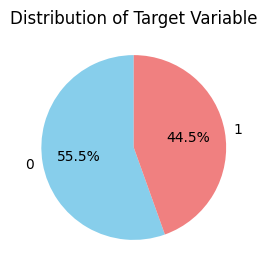

In [183]:
# Count the occurrences of each unique value in the target column
target_counts = all.intention.value_counts()
# Plot the pie chart
plt.figure(figsize=(3, 3))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Distribution of Target Variable')
plt.show()

## 2. Text Processing

In [184]:
# Train test split for model development
train_text, test_text, train_y, test_y = train_test_split(all.tweet,
                                                          all.intention,
                                                          test_size = 0.2,
                                                          stratify = all.intention, 
                                                          random_state = 41)

# Preprocessing text using a tokenizer.
# This converts the texts into sequences of indices representing the 15000 most frequent words
MAX_NB_WORDS = 15000

# Raw text data
texts_train = train_text.astype(str)
texts_test = test_text.astype(str)

# Vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, char_level=False)
# Fit tokenizer to words from training sample
tokenizer.fit_on_texts(texts_train)
# Create sequences using tokenizer
sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

# Sequences have different lengths, so we pad them (add 0s at the end until the sequence is of length 1000)
# Limit and pad sequences - 100 seems enough as majority of tweets are no longer than 11 words (median)
MAX_SEQUENCE_LENGTH = 20

x_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of train tensor:', x_train.shape)

x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of test tensor:', x_test.shape)

# Convert labels to categorical values
train_y = to_categorical(np.asarray(train_y))
print('Shape of train label tensor:', train_y.shape)
test_y = to_categorical(np.asarray(test_y))
print('Shape of test label tensor:', test_y.shape)

Shape of train tensor: (8658, 20)
Shape of test tensor: (2165, 20)
Shape of train label tensor: (8658, 2)
Shape of test label tensor: (2165, 2)


25%,  50%,  75%, 90% quantiles: 
6.0, 11.0, 27.0, 88.0
max length: 1996


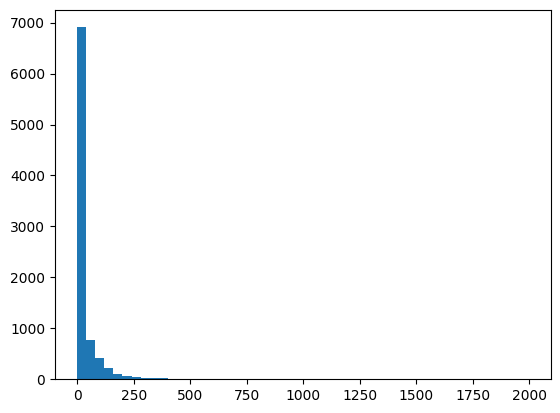

In [185]:
# Length of each sequence
seq_lens = [len(s) for s in sequences_train]
# Find the longest seequence
index_of_longest = max(range(len(sequences_train)), key=lambda i: len(sequences_train[i]))
# Quantiles and longest sequence
quantiles = np.quantile(seq_lens, [0.25, 0.5, 0.75, 0.9])
print(f"25%,  50%,  75%, 90% quantiles: \n{', '.join(f'{q:.1f}' for q in quantiles)}")
print("max length: %d" % max(seq_lens))
# Plot sequence histogram
plt.hist(seq_lens, bins=50);

In [186]:
# Revert the dictionary from tokenizer
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())
# Map any sequence back to words
" ".join([index_to_word[i] for i in sequences_train[index_of_longest]])

'diary log far okay first time writing know sound like emo whiny attention whore bitch need talk personally since nobody really care really help really give fuck stereotype wish could stop looking always left behind stand see others treat different treated like everyone else like since young reminds time making feel empty unwanted tried hard grow least good image yet still grow find meaning try make others laugh root happiness try hard bring others joy yet flame slowly dy feel hold feel something special something wanted feel like need eachother meant sorry dissapointment came different expected say changed honest help looking seeing treat others better sometimes give old childhood memory different kid one really wantedi would talk usually need talk name realise much hurt daily life afraid even go school since looked upon due stereotype although may seem funny deal everyday wishing someone different treating human making think nobody even know feel online real life looked differently a

## 3. Model Development

#### Hyperparameter Search for CNN - LSTM model

In [96]:
# Define the function to create the model
def create_model(x_train, x_test, train_y, test_y,optimizer='adam', dropout_rate_conv=0.2, dropout_rate_lstm=0.2, epochs=5, batch_size=128):
    
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    # Define the embedding layer with 100-dimensional embeddings
    EMBEDDING_DIM = 10
    embedding_layer = Embedding(MAX_NB_WORDS,
                                EMBEDDING_DIM,
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(64, 5, padding='same')(embedded_sequences)
    x = MaxPooling1D(5)(x)
    x = Dropout(dropout_rate_conv)(x)
    x = Conv1D(32, 5, padding='same')(x)
    x = MaxPooling1D(5, padding='same')(x)
    x = Dropout(dropout_rate_conv)(x)
    x = LSTM(32)(x)
    x = Dropout(dropout_rate_lstm)(x)
    predictions = Dense(2, activation='softmax')(x)

    model = Model(sequence_input, predictions)
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc'])

    model.fit(x_train,
              train_y,
              validation_split=0.1,
              epochs=epochs,
              batch_size=batch_size,
              verbose=0)
    
    # Predict
    output_test = model.predict(x_test)
    
    output_test = model.predict(x_test)
    performance = roc_auc_score(test_y[:, 1], output_test[:, 1])

    return model, performance

# Define the parameter values
optimizers = ['adam', 'sgd', 'rmsprop']
dropout_rates_conv = [0.1, 0.2, 0.3, 0.4]
dropout_rates_lstm = [0.1, 0.2, 0.3, 0.4]
epochs = [3]
batch_size = [64]

# Create all combinations
param_combinations = list(product(optimizers, dropout_rates_conv, dropout_rates_lstm, epochs, batch_size))
grid_df = pd.DataFrame(param_combinations, columns=['optimizer', 'dropout_rate_conv', 'dropout_rate_lstm', 'epochs', 'batch_size'])
grid_df["model"] = None
grid_df["performance"] = None
# Deploy each model
for i in range(len(grid_df)):
    optimizer_iter = grid_df['optimizer'][i]
    drop_conv_iter = grid_df['dropout_rate_conv'][i]
    drop_lstm_iter = grid_df['dropout_rate_lstm'][i]
    epoch_iter = grid_df['epochs'][i]
    batch_size_iter = grid_df['batch_size'][i]

    model_iter, performance_iter = create_model(x_train, x_test, train_y, test_y,
                                                optimizer=optimizer_iter,
                                                dropout_rate_conv=drop_conv_iter,
                                                dropout_rate_lstm=drop_lstm_iter,
                                                epochs=epoch_iter,
                                                batch_size=batch_size_iter)

    # Save the results back to the DataFrame
    grid_df.at[i, 'model'] = model_iter
    grid_df.at[i, 'performance'] = round(performance_iter.astype(float)*100,2)

    # Information about progress
    print(f'Progress: {round(100*(i+1)/(len(grid_df)+1),2)}% | Current model ROC AUC score on test sample: {round(100*performance_iter,2)}%')

68/68 [==============================] - 0s 3ms/step
Progress: 2.04% | Current model ROC AUC score on test sample: 94.71%
68/68 [==============================] - 0s 2ms/step
Progress: 4.08% | Current model ROC AUC score on test sample: 94.85%
68/68 [==============================] - 0s 3ms/step
Progress: 6.12% | Current model ROC AUC score on test sample: 94.98%
68/68 [==============================] - 0s 3ms/step
Progress: 8.16% | Current model ROC AUC score on test sample: 94.77%
68/68 [==============================] - 0s 3ms/step
Progress: 10.2% | Current model ROC AUC score on test sample: 95.05%
68/68 [==============================] - 0s 3ms/step
Progress: 12.24% | Current model ROC AUC score on test sample: 94.84%
68/68 [==============================] - 0s 3ms/step
Progress: 14.29% | Current model ROC AUC score on test sample: 94.87%
68/68 [==============================] - 0s 2ms/step
Progress: 16.33% | Current model ROC AUC score on test sample: 94.8%
68/68 [===============

#### Performance results

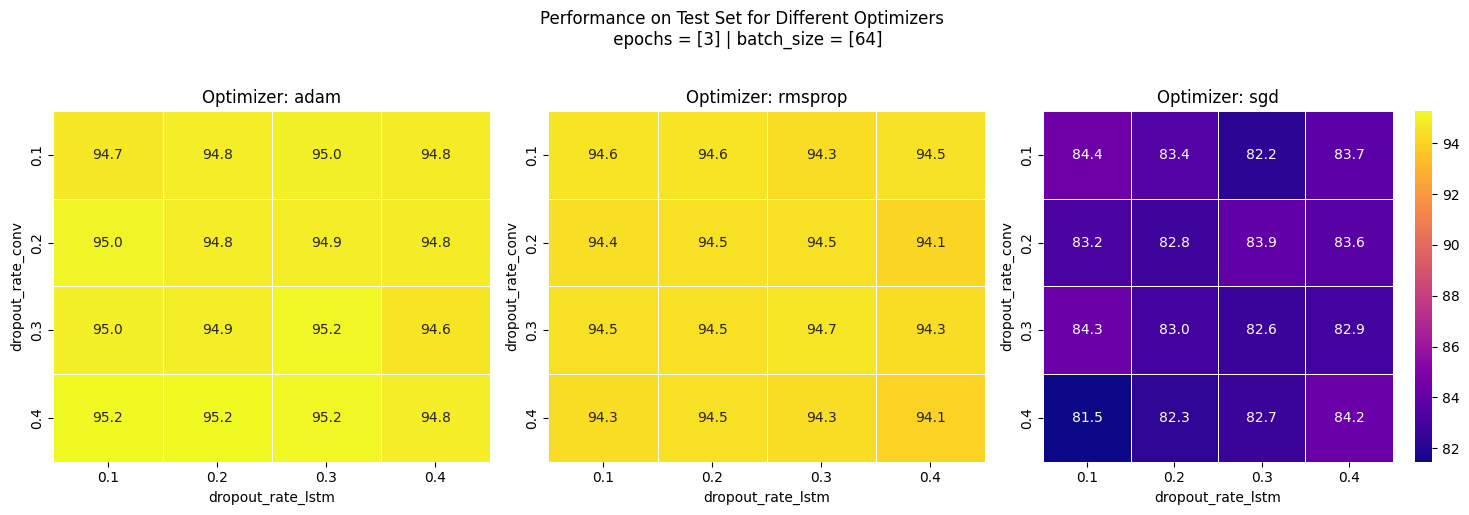

In [187]:
# Pivot the grid search results by calculating average performance for each optimizer
pivot_grid_df = grid_df.pivot_table(index=['dropout_rate_conv', 'dropout_rate_lstm'], columns='optimizer', values='performance', aggfunc='mean')
# Reset the index to bring 'dropout_rate_conv' and 'dropout_rate_lstm' back as columns
pivot_grid_df.reset_index(inplace=True)
# Convert all numeric columns to numeric (in case there are any issues)
pivot_grid_df = pivot_grid_df.apply(pd.to_numeric, errors='coerce')
# Get unique optimizers
optimizers = pivot_grid_df.columns[2:]
# Adjust min and max for heatmap legend
vmin = pivot_grid_df[['adam','sgd','rmsprop']].min().min()
vmax = pivot_grid_df[['adam','sgd','rmsprop']].max().max()
# Create a subplot for each optimizer
fig, axes = plt.subplots(1, len(optimizers), figsize=(15, 5))
# Loop through optimizers and create heatmaps
for i, optimizer in enumerate(optimizers):
    # Only plot the legend next to last subplot
    if i == 2:
        cbar = True
    else:
        cbar = False
    sns.heatmap(pivot_grid_df.pivot(index='dropout_rate_conv', columns='dropout_rate_lstm', values=optimizer),
                cmap="plasma", cbar= cbar, vmin = vmin, vmax =  vmax, annot=True, fmt=".1f", linewidths=.5, ax=axes[i])
    axes[i].set_title(f'Optimizer: {optimizer}')
# Set title
fig.suptitle('Performance on Test Set for Different Optimizers \n epochs = [3] | batch_size = [64]', y=1.02)
# Adjust the layout
plt.tight_layout()
plt.show()

In [188]:
# Take best model
best_model_df = grid_df[grid_df['performance'] == grid_df['performance'].max()]
best_model_df.reset_index(drop = True, inplace = True)
best_model_df

,optimizer,dropout_rate_conv,dropout_rate_lstm,epochs,batch_size,model,performance
0,adam,0.4,0.1,3,64,<keras.src.engine.functional.Functional object...,95.25


#### Training of best model

In [99]:
# Use whole dataset for the training of the best model, using the hyperparameters found during grid search
best_model, performance = create_model(np.concatenate((x_train, x_test)), np.concatenate((x_train, x_test)),
                                      np.concatenate((train_y, test_y)), np.concatenate((train_y, test_y)),
                                       best_model_df.optimizer[0], best_model_df.dropout_rate_conv[0],
                                       best_model_df.dropout_rate_lstm[0], best_model_df.epochs[0], 
                                       best_model_df.batch_size[0])
print(f'Medol performance on trained dataset: {round(100*performance,1)}%')

339/339 [==============================] - 1s 3ms/step
Medol performance on trained dataset: 98.9%


In [101]:
manual_test = ["And all the good girls go ﻿to hell",  # From Bilie Eilish
               "I want to end me",
               "I want to escape",
                "I want to escape from this world",
               "I want to escape to sea side",
               "Please help me",
               "There's no point",
               "Turn off the lights"]

sequences_manual_test = tokenizer.texts_to_sequences(manual_test)
x_manual_test = pad_sequences(sequences_manual_test, maxlen=MAX_SEQUENCE_LENGTH)
prediction = best_model.predict(x_manual_test)

# Create a DataFrame to join manual text with predicted probabilities
result_df = pd.DataFrame({
    'Manual Text': manual_test,
    'Predicted Probabilities': prediction[:,1].tolist(),
})

print(result_df)

1/1 [==============================] - 0s 32ms/step
                          Manual Text  Predicted Probabilities
0  And all the good girls go ﻿to hell                 0.051626
1                    I want to end me                 0.327169
2                    I want to escape                 0.417314
3    I want to escape from this world                 0.556188
4        I want to escape to sea side                 0.403839
5                      Please help me                 0.450301
6                    There's no point                 0.065717
7                 Turn off the lights                 0.088549


## 4. Plugging Lyrics Data

In [189]:
# Use glob to find all CSV files in the specified directory
csv_files = glob.glob('TMSMM\\Project\\Artists\\csv\\' + '*.csv')
# Initialize an empty DataFrame to store the combined data
combined_lyrics = pd.DataFrame()
# Loop through each CSV file, read it, and append it to the combined DataFrame
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    combined_lyrics = pd.concat([combined_lyrics,df], ignore_index=True)
combined_lyrics.dropna(subset = "Lyric", inplace = True)
# Shape of the whole dataset, rows = songs
combined_lyrics.shape

(5981, 7)

In [145]:
# Apply cleaning and lemmatization 
combined_lyrics["Lyric_clean_lem"] = combined_lyrics.Lyric.map(preprocess_text)
# Split lyrics into words
combined_lyrics['words'] = combined_lyrics['Lyric_clean_lem'].str.split()
# Join every 5 words into a line
combined_lyrics['lyrics_to_lines'] = combined_lyrics['words'].apply(lambda x: [' '.join(x[i:i+6]) for i in range(0, len(x), 6)])
combined_lyrics.drop(['words', 'Unnamed: 0'], axis = 1, inplace = True)
combined_lyrics.head()

,Artist,Title,Album,Date,Lyric,Year,Lyric_clean_lem,lyrics_to_lines
0,Ariana Grande,"​thank u, next","thank u, next",2018-11-03,thought i'd end up with sean but he wasn't a m...,2018.0,thought id end sean wasnt match wrote song ric...,"[thought id end sean wasnt match, wrote song r..."
1,Ariana Grande,7 rings,"thank u, next",2019-01-18,yeah breakfast at tiffany's and bottles of bub...,2019.0,yeah breakfast tiffany bottle bubble girl tatt...,"[yeah breakfast tiffany bottle bubble girl, ta..."
2,Ariana Grande,​God is a woman,Sweetener,2018-07-13,you you love it how i move you you love it how...,2018.0,love move love touch one said done youll belie...,"[love move love touch one said, done youll bel..."
3,Ariana Grande,Side To Side,Dangerous Woman,2016-05-20,ariana grande nicki minaj i've been here all ...,2016.0,ariana grande nicki minaj ive night ariana ive...,"[ariana grande nicki minaj ive night, ariana i..."
4,Ariana Grande,​​no tears left to cry,Sweetener,2018-04-20,right now i'm in a state of mind i wanna be in...,2018.0,right im state mind wan na like time aint got ...,"[right im state mind wan na, like time aint go..."


average length: 34.4
max length: 522


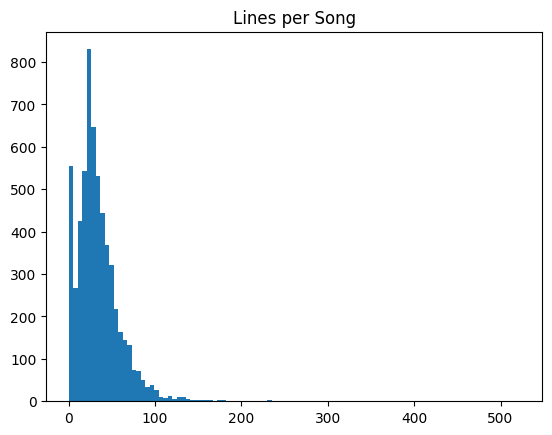

In [146]:
# Length of each song
lines_lyrics = [len(s) for s in combined_lyrics.lyrics_to_lines]
# Average and longest song
print("average length: %0.1f" % np.mean(lines_lyrics))
print("max length: %d" % max(lines_lyrics))
# Plot line histogram
plt.hist(lines_lyrics, bins=100);
plt.title('Lines per Song')
plt.show()

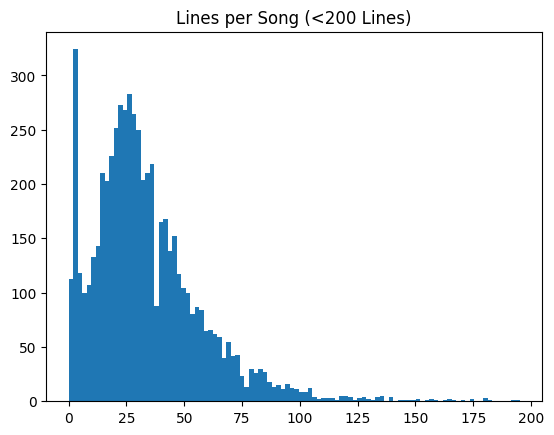

In [147]:
# Songs with less than 200 lines
plt.hist([l for l in lines_lyrics if l < 200], bins=100)
plt.title('Lines per Song (<200 Lines)')
plt.show()

In [120]:
# Limit dataset to songs having at least 5 and at most 200 lines
combined_lyrics = combined_lyrics[(combined_lyrics['lyrics_to_lines'].str.len() > 4) & (combined_lyrics['lyrics_to_lines'].str.len() < 200)]
combined_lyrics.shape

(5466, 8)

In [122]:
# Explode the "lyrics" column
combined_lyrics_expanded = combined_lyrics.explode('lyrics_to_lines')
# Drop unnecessary columns
combined_lyrics_expanded.drop(['Lyric','Lyric_clean_lem'], axis = 1, inplace = True)
combined_lyrics_expanded.reset_index(drop = True, inplace = True)
# Apply tokenizer to lyrics
combined_lyrics_expanded_test = tokenizer.texts_to_sequences(combined_lyrics_expanded.lyrics_to_lines)
print(combined_lyrics_expanded.shape)
combined_lyrics_expanded.head()

(200128, 6)


,Artist,Title,Album,Date,Year,lyrics_to_lines
0,Ariana Grande,"​thank u, next","thank u, next",2018-11-03,2018.0,thought id end sean wasnt match
1,Ariana Grande,"​thank u, next","thank u, next",2018-11-03,2018.0,wrote song ricky listen laugh even
2,Ariana Grande,"​thank u, next","thank u, next",2018-11-03,2018.0,almost got married pete im thankful
3,Ariana Grande,"​thank u, next","thank u, next",2018-11-03,2018.0,wish could say thank malcolm cause
4,Ariana Grande,"​thank u, next","thank u, next",2018-11-03,2018.0,angel pre one taught love one


## 5. Exploring Lyrics of Artists

In [164]:
# Pad inputs from artists
x_artists = pad_sequences(combined_lyrics_expanded_test, maxlen=MAX_SEQUENCE_LENGTH)
# Predictions based on lines
prediction = best_model.predict(x_artists)
# Combine lines and predictions
combined_lyrics_predicted = pd.concat([combined_lyrics_expanded,pd.Series(prediction[:,1], name = "Prob_of_1")], axis = 1)
# Label anything above than 0.5 as suicidal
combined_lyrics_predicted['is_suicidal'] = np.where(combined_lyrics_predicted['Prob_of_1'] > 0.5, 1, 0)

6254/6254 [==============================] - 18s 3ms/step


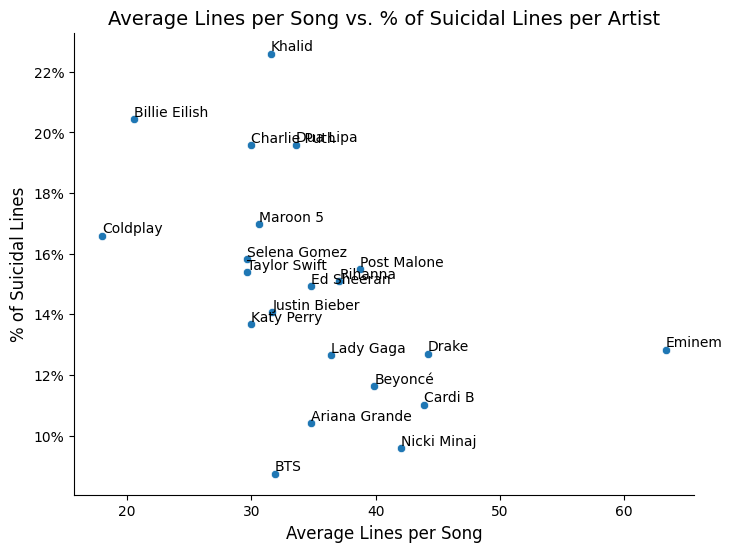

In [178]:
# Overall metrics per artist
artists_overall = combined_lyrics_predicted.groupby('Artist').agg({
    'Title': 'nunique',  # Count unique titles
    'lyrics_to_lines': 'count',     # Count total lyrics
    'is_suicidal': lambda x: x.sum() / x.count()
}).reset_index()
# Calculate the average number of lines per song
artists_overall['average_lines_per_song'] = artists_overall['lyrics_to_lines'] / artists_overall['Title']
# Create scatter plot with Seaborn
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x='average_lines_per_song', y='is_suicidal', data=artists_overall, marker='o')
# Annotate points with artist names
for i, artist in enumerate(artists_overall['Artist']):
    plt.text(artists_overall['average_lines_per_song'][i], artists_overall['is_suicidal'][i], artist, fontsize=10, ha='left', va='bottom')
# Add labels and title
plt.xlabel('Average Lines per Song', fontsize=12)
plt.ylabel('% of Suicidal Lines', fontsize=12)
plt.title('Average Lines per Song vs. % of Suicidal Lines per Artist', fontsize=14)
# Format Y-axis labels as percentages
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
# Remove right and top borders
sns.despine()
# Show the plot
plt.show()

In [166]:
# Remove special characters from BTS
combined_lyrics_predicted['Artist'].replace("BTS (방탄소년단)","BTS", inplace = True)
# Aggregate line predictions to song level
result_song_level = combined_lyrics_predicted.groupby(['Artist', 'Title']).agg({
    'is_suicidal': lambda x: x.sum() / x.count()}).reset_index()
# Aggregate line predictions to artist level
result_album_level = combined_lyrics_predicted.groupby(['Artist', 'Album']).agg({
    'is_suicidal': lambda x: x.sum() / x.count()}).reset_index()

In [167]:
# Most depressive songs of artist'
# Find the row with the maximum value of the is_suicidal metric for each artist
max_song = result_song_level.loc[result_song_level.groupby('Artist')['is_suicidal'].idxmax()]
# Display the most depressive song of given artist
max_song[['Artist', 'Title', 'is_suicidal']].sort_values(by = 'is_suicidal', ascending = False)

,Artist,Title,is_suicidal
430,BTS,RUN (Ballad Mix),1.000000
4422,Post Malone,Jonestown (Interlude),0.933333
3389,Katy Perry,Small Talk (Lost Kings Remix),0.833333
1249,Coldplay,Everybody Hurts,0.812500
3136,Justin Bieber,Somebody to Love (J-Stax Remix),0.763158
1139,Charlie Puth,River,0.733333
718,Beyoncé,I’m Somebody,0.727273
4546,Rihanna,Cry (Steve Mac Classic Mix),0.724638
5298,Taylor Swift,Stupid Boy,0.722222
2180,Ed Sheeran,Drunk (Jayglo Remix),0.714286


In [168]:
# Most depressive album of artist'
# Find the row with the maximum value of the is_suicidal metric for each artist
max_album = result_album_level.loc[result_album_level.groupby('Artist')['is_suicidal'].idxmax()]
# Display the most depressive song of given artist
max_album[['Artist', 'Album', 'is_suicidal']].sort_values(by = 'is_suicidal', ascending = False)

,Artist,Album,is_suicidal
220,Dua Lipa,Blow Your Mind (Mwah) [Remixes],0.642424
175,Coldplay,Talk - The Remixes,0.632653
511,Rihanna,Unfaithful (Remixes),0.607143
125,Charlie Puth,Nine Track Mind (Deluxe),0.581081
25,Ariana Grande,Women of Soul: In Performance at the White House,0.538462
382,Khalid,The Annual 2020,0.533333
441,Maroon 5,The Limited Set - EP,0.500000
254,Ed Sheeran,I Don’t Care Where I Go When I Die,0.444444
106,Billie Eilish,Ocean Eyes (The Remixes) - EP,0.420455
523,Selena Gomez,Disney Channel Playlist,0.400000


C:\Users\husee\AppData\Local\Temp\ipykernel_56112\674608127.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_values_song = result_song_level.groupby('Artist')['is_suicidal'].median()


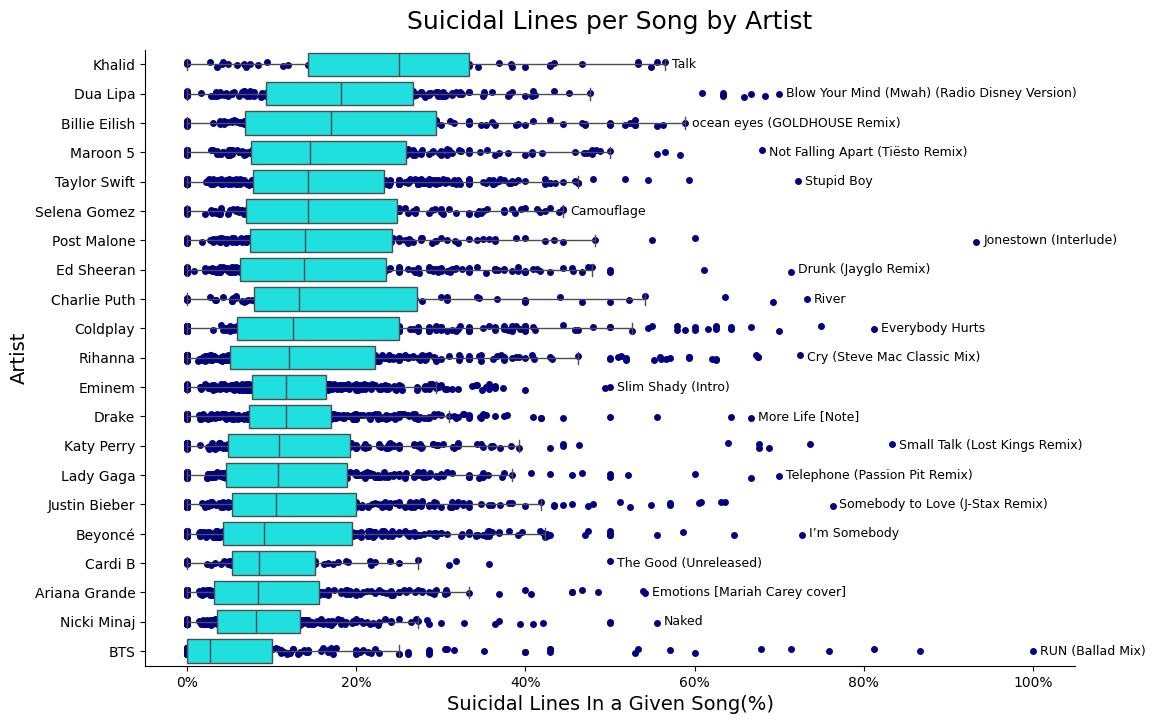

In [172]:
# Calculate the median of 'is_suicidal' for each artist
median_values_song = result_song_level.groupby('Artist')['is_suicidal'].median()
# Sort the artists based on the median values in descending order
artist_order_song = median_values_song.sort_values(ascending=False).index
# Update the 'Artist' column as a categorical variable with the sorted order
result_song_level['Artist'] = pd.Categorical(result_song_level['Artist'], categories=artist_order_song, ordered=True)

plt.figure(figsize=(12, 8))

sns.boxplot(y="Artist", x="is_suicidal", data=result_song_level, color="cyan", showfliers = False)
sns.stripplot(y="Artist", x="is_suicidal", data=result_song_level,jitter=True, zorder=1, color = "navy")

# Add title and labels
plt.title('Suicidal Lines per Song by Artist', fontsize=18, pad=15)
plt.xlabel('Suicidal Lines In a Given Song(%)', fontsize=14)
plt.ylabel('Artist', fontsize=14)

# Annotate the maximum for each artist with the label from the 'Title' column
for artist in result_song_level['Artist'].unique():
    max_value = result_song_level[result_song_level['Artist'] == artist]['is_suicidal'].max()
    song_label = result_song_level[(result_song_level['Artist'] == artist) & (result_song_level['is_suicidal'] == max_value)]['Title'].values[0]
    plt.annotate(f'{song_label}', xy=(max_value, artist), xytext=(5, 0), textcoords='offset points', ha='left', va='center', fontsize=9, color='black')

# Format x-axis labels as percentages without decimals
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(100*x)}%'))
# Remove right and top borders
sns.despine()
# Show plot
plt.show()

C:\Users\husee\AppData\Local\Temp\ipykernel_56112\2080021393.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_values_album = result_album_level.groupby('Artist')['is_suicidal'].median()
C:\Users\husee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54868 (\N{HANGUL SYLLABLE HWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\husee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\husee\AppData\Local\

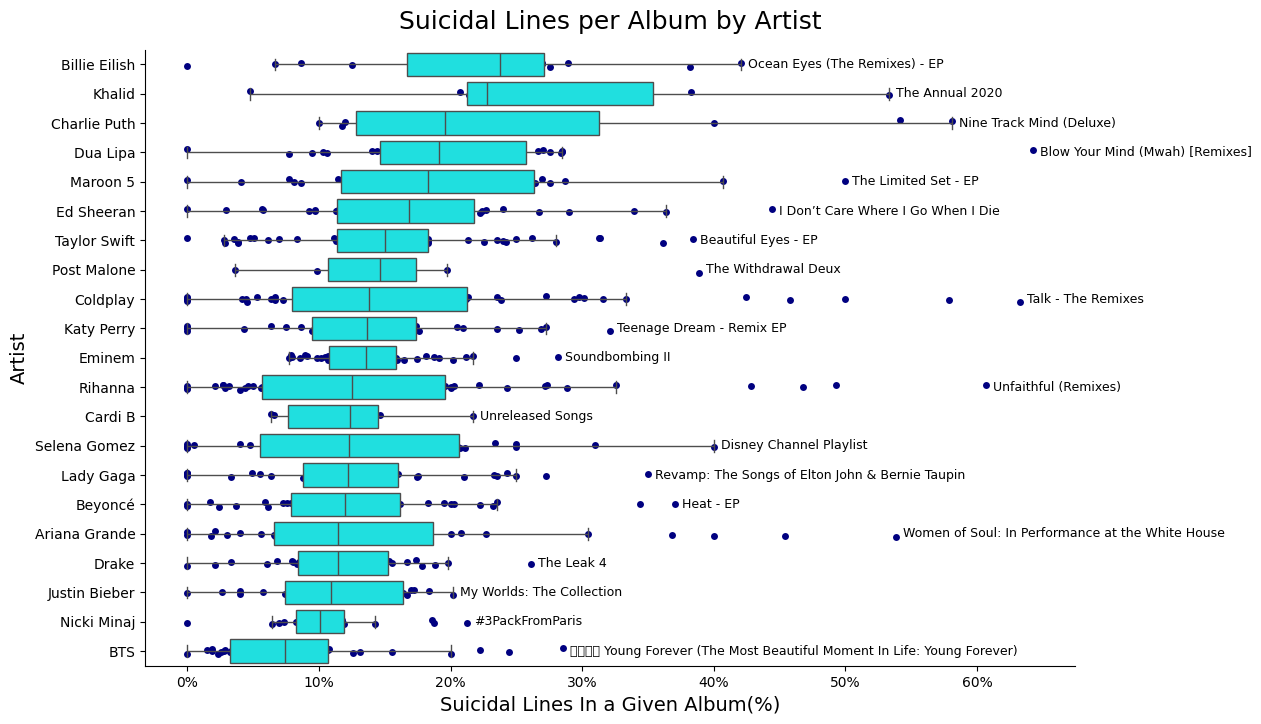

In [171]:
# Calculate the median of 'is_suicidal' for each artist
median_values_album = result_album_level.groupby('Artist')['is_suicidal'].median()
# Sort the artists based on the median values in descending order
artist_order_album = median_values_album.sort_values(ascending=False).index
# Update the 'Artist' column as a categorical variable with the sorted order
result_album_level['Artist'] = pd.Categorical(result_album_level['Artist'], categories=artist_order_album, ordered=True)
plt.figure(figsize=(12, 8))

sns.stripplot(y="Artist", x="is_suicidal", data=result_album_level,jitter=True, zorder=1, color = "navy")
sns.boxplot(y="Artist", x="is_suicidal", data=result_album_level, color="cyan", showfliers = False)
# Add title and labels
plt.title('Suicidal Lines per Album by Artist', fontsize=18, pad = 15)
plt.xlabel('Suicidal Lines In a Given Album(%)', fontsize=14)
plt.ylabel('Artist', fontsize=14)

# Annotate the maximum for each artist with the label from the 'album' column
for artist in result_album_level['Artist'].unique():
    max_value = result_album_level[result_album_level['Artist'] == artist]['is_suicidal'].max()
    album_label = result_album_level[(result_album_level['Artist'] == artist) & (result_album_level['is_suicidal'] == max_value)]['Album'].values[0]
    plt.annotate(f'{album_label}', xy=(max_value, artist), xytext=(5, 0), textcoords='offset points', ha='left', va='center', fontsize=9, color='black')

# Format x-axis labels as percentages without decimals
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(100*x)}%'))
# Remove right and top borders
sns.despine()
# Show plot
plt.show()